In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import seaborn as sns
import re
import nltk
import torch
from datetime import datetime, timedelta
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Dense, Dropout, Input, Embedding, LSTM
from tensorflow.keras import backend as K
from allennlp.modules.elmo import Elmo, batch_to_ids
from transformers import AutoTokenizer, AutoModel
from keras_self_attention import SeqSelfAttention

2024-01-30 11:32:47.076421: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/katarina_glorija/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
conversation_df = pd.read_excel('data/Conversations_without_frustrationTutor.xlsx')
conversation_df.head()

,Id,LearnerId,DateTime,Konverzacije,Emocija,Aspekt,Obrazloženje
0,1093,-9991,2023-05-03 14:26:41.179435+02,"{""Zdravo! Kako se osećaš povodom učenja u ovom...",Neutralno,Lekcija,NaN
1,705,271,2023-05-02 12:55:06.690703+02,"{""Zdravo! Kako se osećaš povodom učenja u ovom...",Angažovanost,Zadaci,NaN
2,1083,-9991,2023-05-03 13:44:39.768422+02,"{""Zdravo! Kako se osećaš povodom učenja u ovom...",Neutralno,Lekcija,NaN
3,656,199,2023-05-01 22:48:41.422144+02,"{""Zdravo! Kako se osećaš povodom učenja u ovom...",Nezainteresovanost,Tutor,NaN
4,1149,271,2023-05-03 18:07:40.166059+02,"{""Zdravo! Kako se osećaš povodom učenja u ovom...",Zbunjenost,Instrukcioni materijali,NaN


In [22]:
class_counts = conversation_df['Emocija'].value_counts()
total_instances = len(conversation_df)
class_percentages = (class_counts / total_instances) * 100
print(class_percentages)

Emocija
Angažovanost          37.486911
Neutralno             26.701571
Umor                  15.602094
Frustracija            8.062827
Zbunjenost             6.178010
Nezainteresovanost     5.968586
Name: count, dtype: float64


In [3]:
temp_dict_emocija = {
    'Angažovanost' : 1,
    'Neutralno' : 1,
    'Frustracija' : 2,
    'Zbunjenost' : 3,
    'Nezainteresovanost' : 4,
    'Umor' : 5,
}

temp_dict_aspekt = {
    'Lekcija' : 1,
    'Zadaci' : 2,
    'Instrukcioni materijali' : 3,
    'Tutor' : 4,
    'Projekat' : 5,
    'Drugi aspekt' : 6,
}

conversation_df_copy = conversation_df.copy()
conversation_df_copy['Emocija'] = conversation_df_copy['Emocija'].map(temp_dict_emocija)
conversation_df_copy['Aspekt'] = conversation_df_copy['Aspekt'].map(temp_dict_aspekt)

In [4]:
conversation_df_copy.head()

,Id,LearnerId,DateTime,Konverzacije,Emocija,Aspekt,Obrazloženje
0,1093,-9991,2023-05-03 14:26:41.179435+02,"{""Zdravo! Kako se osećaš povodom učenja u ovom...",1,1,NaN
1,705,271,2023-05-02 12:55:06.690703+02,"{""Zdravo! Kako se osećaš povodom učenja u ovom...",1,2,NaN
2,1083,-9991,2023-05-03 13:44:39.768422+02,"{""Zdravo! Kako se osećaš povodom učenja u ovom...",1,1,NaN
3,656,199,2023-05-01 22:48:41.422144+02,"{""Zdravo! Kako se osećaš povodom učenja u ovom...",4,4,NaN
4,1149,271,2023-05-03 18:07:40.166059+02,"{""Zdravo! Kako se osećaš povodom učenja u ovom...",3,3,NaN


In [5]:
nan_columns = conversation_df_copy.columns[conversation_df_copy.isnull().any()]
print("Columns with NaN values:", nan_columns)

Columns with NaN values: Index(['Obrazloženje'], dtype='object')


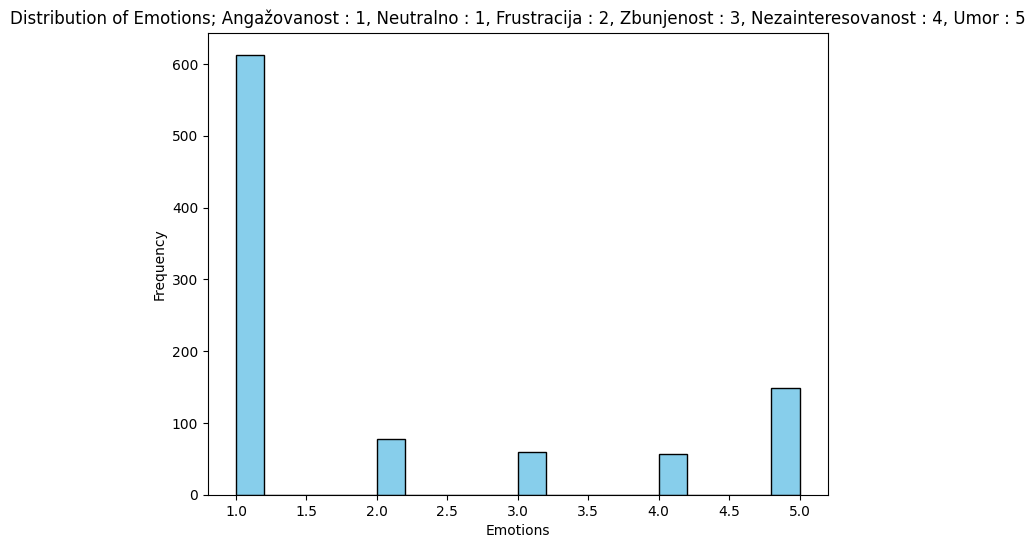

In [4]:
plt.figure(figsize=(8, 6))
plt.hist(conversation_df_copy['Emocija'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Emotions; Angažovanost : 1, Neutralno : 1, Frustracija : 2, Zbunjenost : 3, Nezainteresovanost : 4, Umor : 5')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.show()

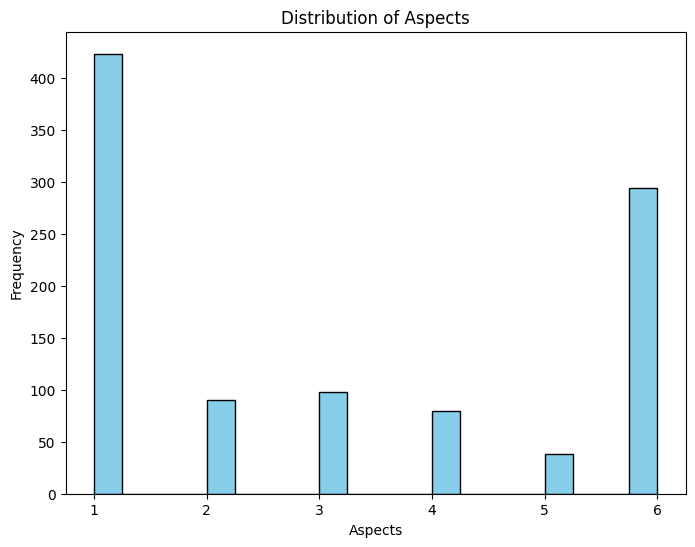

In [7]:
plt.figure(figsize=(8, 6))
plt.hist(conversation_df_copy['Aspekt'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Aspects')
plt.xlabel('Aspects')
plt.ylabel('Frequency')
plt.show()

In [5]:
X_emotion = conversation_df_copy['Konverzacije']
X_aspect = conversation_df_copy['Konverzacije']

y_emotion = conversation_df_copy['Emocija']
y_aspect = conversation_df_copy['Aspekt']

X_train, X_test, y_train, y_test = train_test_split(X_emotion, y_emotion, test_size=0.2, stratify=y_emotion)

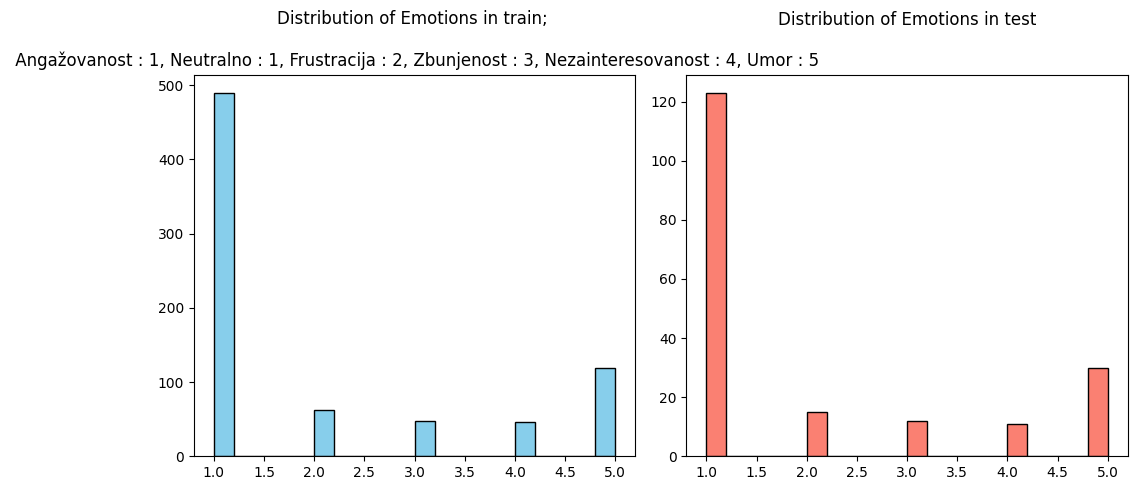

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].hist(y_train, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Emotions in train; \n \n Angažovanost : 1, Neutralno : 1, Frustracija : 2, Zbunjenost : 3, Nezainteresovanost : 4, Umor : 5')

axes[1].hist(y_test, bins=20, color='salmon', edgecolor='black')
axes[1].set_title('Distribution of Emotions in test\n\n')

plt.tight_layout()
plt.show()

## Preprocessing

In [5]:
model_name = "classla/bcms-bertic"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
options_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://allennlp.s3.amazonaws.com/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"
elmo = Elmo(options_file, weight_file, 1, dropout=0)

Some weights of the model checkpoint at classla/bcms-bertic were not used when initializing ElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
def extract_second_sentence(conversation):
    start_index = conversation.find('-') + 1
    end_index = conversation.find('-', start_index)
    second_sentence = conversation[start_index:end_index].strip() if end_index != -1 else None

    return second_sentence

conversation_df['Prvi_odgovor'] = conversation_df['Konverzacije'].apply(extract_second_sentence)

In [32]:
sentences = conversation_df['Prvi_odgovor']
sequence_lengths = [len(seq) for seq in sentences]
max_seq_length = max(sequence_lengths)
print("Max Sequence Length:", max_seq_length)

Max Sequence Length: 206


In [7]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    stop_words = set(stopwords.words('serbian'))
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

# Tokenize and embed text using Elmo
def embed_with_elmo(text):
    if text == "":
        return np.zeros(1024);
    text = preprocess_text(text)
    if text == "":
        return np.zeros(1024);
    print(text)
    character_ids = batch_to_ids(text)
    embeddings = elmo(character_ids)
    embeddings = embeddings['elmo_representations'][0][0]
    embeddings = embeddings.detach().numpy()
    average_embedding = np.mean(embeddings, axis=0)
    return average_embedding.copy()

def embed_with_bert(text):
    sentences = text.split('.')
    tokenized_sentences = [tokenizer(sentence.strip(), return_tensors="pt") for sentence in sentences if sentence.strip()]
    inputs = {
        'input_ids': torch.cat([sentence['input_ids'] for sentence in tokenized_sentences], dim=1),
        'attention_mask': torch.cat([sentence['attention_mask'] for sentence in tokenized_sentences], dim=1),
    }
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state
    average_embeddings = torch.mean(embeddings, dim=1)
    return average_embeddings.detach().numpy()

In [8]:
bert_embeddings = np.vstack(conversation_df['Prvi_odgovor'].apply(embed_with_bert))
bert_df = pd.DataFrame(bert_embeddings)
bert_df.to_csv("embeddings/bert_embeddings_without_preprocessing_sentences.csv", index=False)

{'input_ids': tensor([[    2, 22299,  1015,     3]]), 'attention_mask': tensor([[1, 1, 1, 1]])}
{'input_ids': tensor([[    2, 12240,  8988, 23986,     3]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}
{'input_ids': tensor([[   2, 2499,    3]]), 'attention_mask': tensor([[1, 1, 1]])}
{'input_ids': tensor([[    2,  2311,  6736,  1917,  1949, 10436, 23986,     3]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}
{'input_ids': tensor([[    2,  2571,  2171, 23770, 23986,     3]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}
{'input_ids': tensor([[    2,  2463,  6573,  5128,  1917,    77,  7522,  3875,    16,  2219,
          4333,  1019,  1944,    89,  6513, 11959,  2718,  2155, 12699, 13023,
          2202,  2916,  2195,  1944,  3127,  2792, 12569, 26184,  1019,  3688,
         20330,  2243,  2095,  3380,  3618,  1944,  1948,  3931,  2467,    77,
          3548, 30376,     3,     2,  2259, 30675,  1944,  8544,  1955,     3]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 

In [9]:
elmo_embeddings = np.vstack(conversation_df['Prvi_odgovor'].apply(embed_with_elmo))
elmo_df = pd.DataFrame(elmo_embeddings)
elmo_df.to_csv("embeddings/elmo_embeddings.csv", index=False)

dobor
koncentrisano
dobro
totalno ne motivisano
dekoncentrisano
inspirisano uzbuđeno planiram toku narednih nekoliko dana rasporedim tutora tako svaki dan pažljivo pređem lekciju bih mogao se posvetim drugim obavezama pa hajde počnemo
prilicno dobro
dobro
lose
isfrustrirano
lose
lose
lose
iritira me jako
pomalo umorno
dobro
odlicno
lepo
vrlo lepo
super
lepo
potpuno nemotivisano nekoncentrisano
lepo
jako lose
lose
stresno
odlicno
rekao odlicno
odlicno
dobro
super
ba sjajno
odlicno
odlicno
okej
ne volim online ucenje nista ne menja interakciju profesoraasistenta studentnom
lose
lose
ne znam
ne znam
ne znam
ne znam
malo se zamorio
super
dobro
energicno
lose
lose
ok
fokusirano
dobro
dobro
spremno rad
katastrofa ne mozemo povezemo proto fajl
raspolozenje mi opalo
primorano
lose
istresirano
uzas
fino
jako lepo al radije bih isla setnju
dobro
ne entuzijastično
rad
malo dosadno
smoreno
umorno
dobro
dobro
raspolozeno
ok
dobro
dobro
dobro
odlicno
zanima me nova lekcija
raspolozena jos detaljnije

In [16]:
X = pd.read_csv('embeddings/elmo_embeddings.csv')
y = conversation_df_copy['Emocija']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [17]:
embedding_size = 1024
#embedding_size = 768
num_classes = 6
max_sequence_length = 296

In [18]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(embedding_size,)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [19]:
def f1_score_train_model(y_true, y_pred):
    # Calculating Precision and Recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    # Calculating F1 Score
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               262400    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 774       
                                                                 
Total params: 296070 (1.13 MB)
Trainable params: 296070 (1.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/15
24/24 [

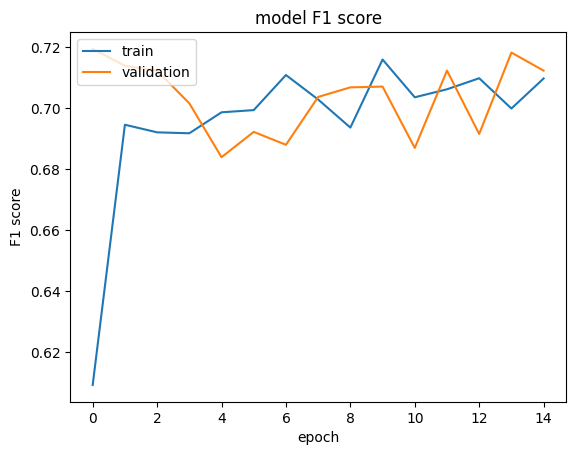

In [20]:
model.compile(loss='categorical_crossentropy', metrics=[f1_score_train_model])

model.summary()

batch_size = 32
epochs = 15

y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

history = model.fit(
    X_train, y_train_one_hot,
    validation_data=(X_test, y_test_one_hot),
    batch_size=batch_size,
    epochs=epochs
)
plt.plot(history.history['f1_score_train_model'])
plt.plot(history.history['val_f1_score_train_model'])
plt.title('model F1 score')
plt.ylabel('F1 score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
y_pred = model.predict(X_test)
y_pred_classes = tf.argmax(y_pred, axis=1)
y_test_classes = tf.argmax(y_test_one_hot, axis=1)

f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

print(f"F1 Score: {f1}")

6/6 [==============================] - 0s 3ms/step
F1 Score: 0.6351019300929436
